In [1]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse


# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# The data

We need to predict the price of diamonds, and we are measured by the RMSLE.

## Get the data

In [ ]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving diamonds.csv to diamonds.csv


In [5]:
diamonds = pd.read_csv('diamonds.csv', index_col='#')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
#,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


> **Note:** This is a good point for some [EDA of the diamonds dataset](https://drive.google.com/drive/folders/1cbewTd42Qm4aHBBb8UtwKeNHrpI71xJp?usp=sharing).

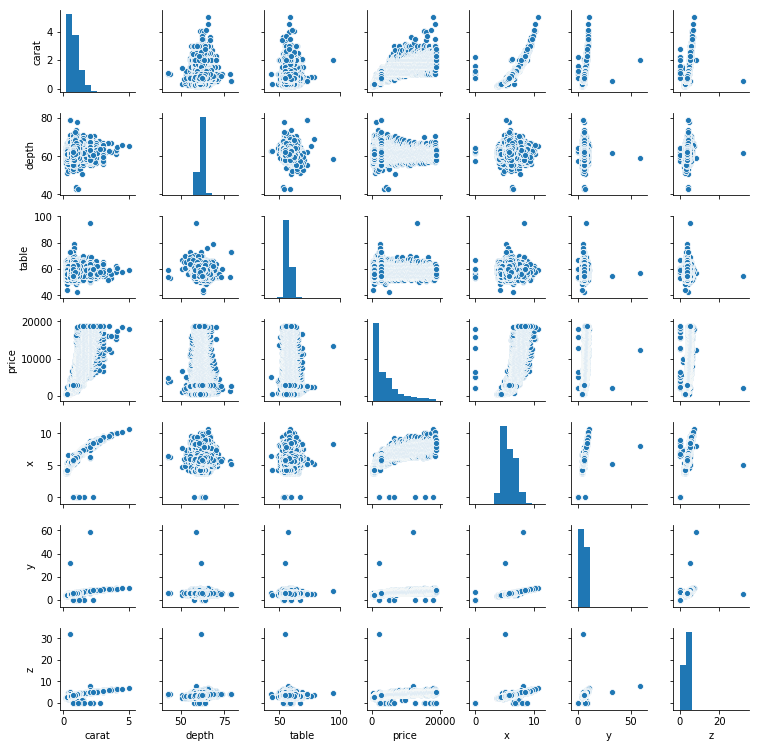

In [ ]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5)

> **Note:** We can go back to this visualization and see our progrees as we manipulate the data.

## Cleaning

This step makes sure only relevant data is collected.

### Dropping non-physical diamonds

In [6]:
def drop_zeros(df):
    return df.loc[df.x * df.y * df.z != 0]

In [7]:
zeros_dropper = FunctionTransformer(drop_zeros, validate=False)

In [8]:
diamonds = zeros_dropper.fit_transform(diamonds)

In [ ]:
diamonds.shape

(53920, 10)

### Removing non-round diamonds

In [9]:
def select_round(X, diff_max=0.1):
    return X.loc[(X.x - X.y).abs() < diff_max]

In [10]:
cut_rounder = FunctionTransformer(select_round, validate=False, kw_args={'diff_max': 0.1})

In [11]:
diamonds = cut_rounder.fit_transform(diamonds)

In [ ]:
diamonds.shape

(52004, 10)

### Removing outliers

#### 6-sigma range

For illustration purposes we illustrate a simple and common outlier removing technique, based on keeping the values between 3 times the standard deviation. Many times it is advisable to apply a more robust process.

In [12]:
for col in diamonds.columns:
    if diamonds[col].dtype == 'float64':
        std = diamonds[col].std()
        ave = diamonds[col].mean()
        diamonds = diamonds.loc[diamonds[col].between(ave-3*std, ave+3*std)]
        print(f'processing {col:10} --> {diamonds.shape[0]:5} diamonds remain')

processing carat      --> 51543 diamonds remain
processing depth      --> 50918 diamonds remain
processing table      --> 50524 diamonds remain
processing x          --> 50524 diamonds remain
processing y          --> 50524 diamonds remain
processing z          --> 50520 diamonds remain


#### Questionable data

Very often some of the data simply doesn't make sense. If you are lucky to have a domain expert, they will explain how it got there, but for your model it is better without such data samples. In our case we've noticed some bizzare `z`-values, when compared to `x` and `y`.

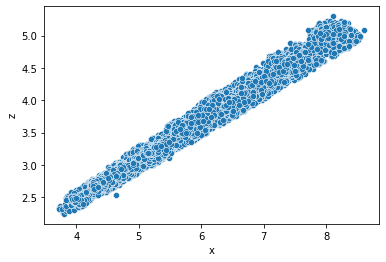

In [15]:
sns.scatterplot(x='x', y='z', data=diamonds)

The problematic data points can be removed manually, but...

> **Your turn:** Create a linear model for predicting `z` from `x`, and then remove every data point with $abs(\hat{z}_i-z_i)>0.35$.

> **Note:** This is a good example of how we use a regression model as an intermediate tool rather than a final goal.

> **Discussion:** How do we choose the threshold? Should it be tight or loose?

##### Solution

In [13]:
xz_model = LinearRegression().fit(diamonds[['x']], diamonds.z)
z_pred = xz_model.predict(diamonds[['x']])
diamonds = diamonds.loc[(diamonds.z-z_pred).abs()<0.35]

In [14]:
diamonds.shape

(50511, 10)

#### More questionable data

Let's have a look on the relation between `x`/`y`/`z` and `carat`.

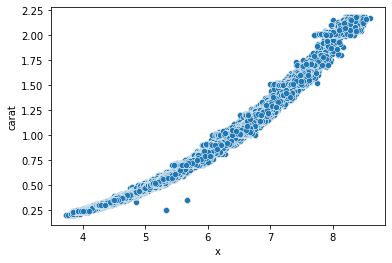

In [16]:
ax = sns.scatterplot(x='x', y='carat', data=diamonds)
# ax.set_xlim([5, 6])
# ax.set_ylim([0, 1])

> **Your turn:** Remove the outliers.

##### Method 1 - manually

In [17]:
outliers = diamonds.loc[(diamonds.x>5) & (diamonds.carat<0.4)]
outliers

,carat,cut,color,clarity,depth,table,price,x,y,z
#,,,,,,,,,,
36652,0.35,Premium,J,VS1,62.4,58.0,949,5.67,5.64,3.53
36653,0.35,Premium,J,VS1,62.4,58.0,949,5.67,5.64,3.53
41020,0.25,Premium,G,SI2,59.0,60.0,1186,5.33,5.28,3.12
41021,0.25,Premium,G,SI2,58.8,60.0,1186,5.33,5.28,3.12


In [18]:
diamonds.drop(outliers.index, inplace=True)

In [ ]:
diamonds.shape

(50507, 10)

##### Method 2 - exponential regression

Realizing that the relation between `x` and `carat` may be exponential, we apply this regression.

In [19]:
def exponential(x, a, b, c, d):
    return a + b*np.exp(c*x+d)

popt, _ = curve_fit(exponential, xdata=diamonds.x, ydata=diamonds.carat)
print(popt)
a, b, c, d = popt

[-0.48151245  0.14196704  0.30761321  0.37386464]


Text(6, 0.5, '$carat = -0.47+19.56 x exp(0.3x-4.56)$')

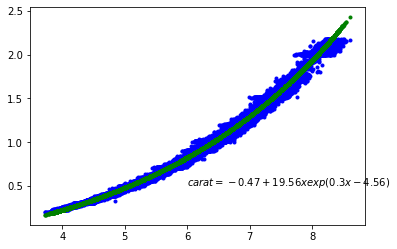

In [20]:
carat_pred = diamonds.x.apply(exponential, a=a, b=b, c=c, d=d)
plt.plot(diamonds.x, diamonds.carat, '.b', 
              diamonds.x, carat_pred, '.g')
plt.text(6, 0.5, r'$carat = -0.47+19.56 x exp(0.3x-4.56)$')

Why we can evaluate the residuals and remove data points as we wish.

In [21]:
residuals = (diamonds.carat - carat_pred).abs()

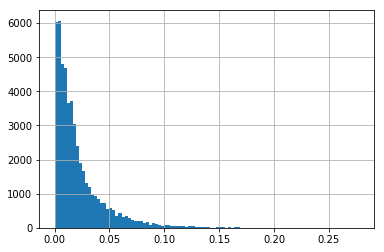

In [ ]:
residuals.hist(bins=100)

In [ ]:
diamonds = diamonds.loc[residuals < 0.2]

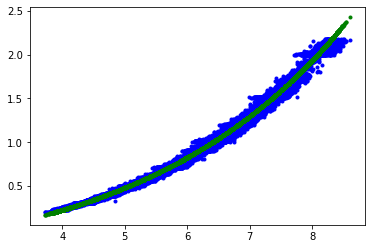

In [22]:
carat_pred = diamonds.x.apply(exponential, a=a, b=b, c=c, d=d)
ax = plt.plot(diamonds.x, diamonds.carat, '.b', 
              diamonds.x, carat_pred, '.g')

In [ ]:
diamonds.shape

(50475, 10)

> **Note:** Looking at the linear residuals may be misleading. It is often useful to look at the log-error, implemented by

>> `log_residuals = (np.log1p(diamonds.carat) - np.log1p(carat_pred)).abs()`.

> **Note:** There are other methods for anomaly detection, e.g. LOF (by neighbors) and isolation forest (by trees).

> **Discussion:** Consider the cleaning step in other domains, such as advertising, life-time value, etc.

> **Discussion:** In the next steps we manipulate the data to make it as suitable as possible for our chosen models. What does it mean "suitable" and why it may be different for different models?

## Feature Selection

For many practical reasons, and also due to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning), it is always a good idea to reduce the number of features. One of the methods of doing that is by removing features completely.

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
#,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48


### Relevance

Very often, some of the features are irrelevant for the problem and can be removed. 

Other methods involve statistics in order to score the relevancy of some features (e.g. [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)). We will skip this for now.

### Correlation

Many times columns are closely related to other columns and therefore can be dropped. This is usually more relevant to numerical data, so we use [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html).

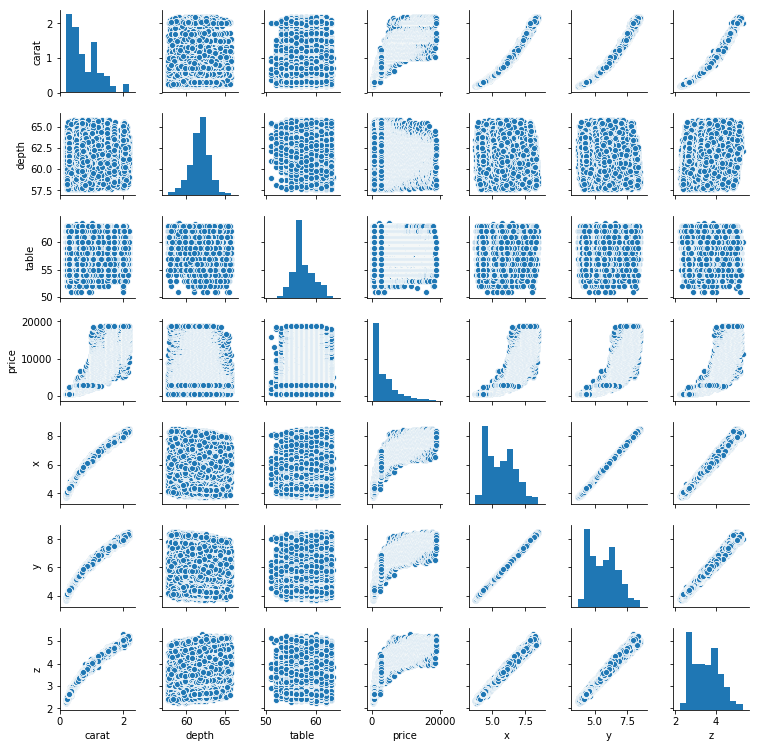

In [ ]:
diamonds_num = diamonds.select_dtypes(include=np.number)
sns.pairplot(diamonds_num, height=1.5)

> **Warning:** Most of the time, when people talk about correlation between features they are talking about **linear correlation**. In our case `x`, `y` and `z` share a high linear correlation. However, the `carat` is clearly correlated with them, though not linearly.

It is clear that `x`, `y` and `z` are highly linearly correlated, and this can be confirmed by evaluating the linear correlation between them using the [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) method. This is usually visualized using a heat map.

In [23]:
diamonds.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.013884,0.186571,0.923556,0.981927,0.981410,0.980948
depth,0.013884,1.000000,-0.277377,-0.016852,-0.031057,-0.032823,0.076936
table,0.186571,-0.277377,1.000000,0.134091,0.192157,0.187779,0.160243
price,0.923556,-0.016852,0.134091,1.000000,0.885312,0.886278,0.881534
x,0.981927,-0.031057,0.192157,0.885312,1.000000,0.999102,0.993722
y,0.981410,-0.032823,0.187779,0.886278,0.999102,1.000000,0.993524
z,0.980948,0.076936,0.160243,0.881534,0.993722,0.993524,1.000000


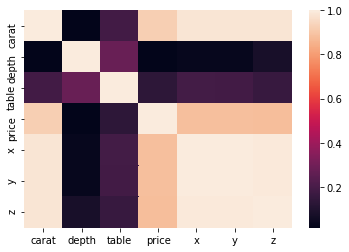

In [ ]:
sns.heatmap(diamonds.corr().abs())

Due to the high correlation we decide to drop all dimension besides the `carat`.

In [ ]:
diamonds.drop(['x', 'y', 'z'], axis=1, inplace=True)

KeyError: ignored

> **Discussion:** What about the features with low correlation with the target (`price`)? Should we drop them?

## Preprocessing

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price
#,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,326
2,0.21,Premium,E,SI1,59.8,61.0,326
4,0.29,Premium,I,VS2,62.4,58.0,334
5,0.31,Good,J,SI2,63.3,58.0,335
6,0.24,Very Good,J,VVS2,62.8,57.0,336


### Scaling

#### Features

For many reasons, it is often advisable to scale the features. One of the reasons is to make sure that none of the featrues "shadows" the others.

In [ ]:
# diamonds_num = diamonds.select_dtypes(include=np.number)
# sns.pairplot(diamonds_num, height=1.5)

Based on [This diamonds explanation](https://rstudio-pubs-static.s3.amazonaws.com/316651_5c92e58ef8a343e4b3f618a7b415e2ad.html), we know that `depth` and `table` actually represent ratios, so we can simply divide them by $100$.

In [ ]:
diamonds[['depth', 'table']] = diamonds[['depth', 'table']] / 100

In [ ]:
diamonds.head()

,carat,cut,color,clarity,depth,table,price
#,,,,,,,
1,0.23,Ideal,E,SI2,0.615,0.55,326
2,0.21,Premium,E,SI1,0.598,0.61,326
4,0.29,Premium,I,VS2,0.624,0.58,334
5,0.31,Good,J,SI2,0.633,0.58,335
6,0.24,Very Good,J,VVS2,0.628,0.57,336


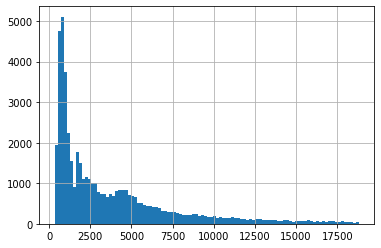

In [25]:
diamonds.price.hist(bins=100)

#### Target

Also, it is easier for most models to predict a more regular target, so we can apply any "reversible" transformation and predict the transformed values. Just don't forget to transform it back...

In our case, the target distribution (`price`) has a long tail at the high values, so we can apply the log transformation, conveniently implemented by [`np.log1p()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html).

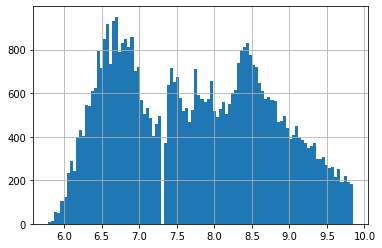

In [26]:
log_price = np.log1p(diamonds.price)
log_price.hist(bins=100)

In [27]:
diamonds.price = log_price

In [28]:
diamonds.rename({'price': 'log_price'}, inplace=True, axis=1)

In [29]:
diamonds.head()

,carat,cut,color,clarity,depth,table,log_price,x,y,z
#,,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,5.789960,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,5.789960,3.89,3.84,2.31
4,0.29,Premium,I,VS2,62.4,58.0,5.814131,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,5.817111,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,5.820083,3.94,3.96,2.48


> **Note:** There are other useful transformations, such as exponent, power, etc.

> **Discussion:** We have to remind ourselves how we are scored. We can eitehr "turn the wheel" before evaluating the final score on the predictions in the original scale, or we need to change the score function as well. For example, consider two alternatives for the diamonds dataset - in one you don't scale and score with RMSLE, and in the second you scale and score with RMSE. What is the differnce between these two approaches? 

> **Note:** We note specifically that the RMSE of the `log_price` predictions is equivalent to the RMSLE of the `price` predictions.

### Categorical data

All models expect numerical input, therefore it is mandatory to transform the categorical data. Since there are several technique to do that, we will wait with the final decision and simply convert them into ordering integers.

In [30]:
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
cut_map = dict(zip(cut_order, range(len(cut_order))))

color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
color_map = dict(zip(color_order, range(len(color_order))))

clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
clarity_map = dict(zip(clarity_order, range(len(clarity_order))))

In [31]:
cut_map

{'Fair': 0, 'Good': 1, 'Ideal': 4, 'Premium': 3, 'Very Good': 2}

In [32]:
diamonds.loc[:, 'cut'] = diamonds['cut'].map(cut_map)
diamonds.loc[:, 'color'] = diamonds['color'].map(color_map)
diamonds.loc[:, 'clarity'] = diamonds['clarity'].map(clarity_map)

> **Note:** This can also be applied using the [`OrdinalOrder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) transformer.

In [36]:
diamonds.head()

,carat,cut,color,clarity,depth,table,log_price,x,y,z
#,,,,,,,,,,
1,0.23,4,5,1,0.615,0.55,5.789960,3.95,3.98,2.43
2,0.21,3,5,2,0.598,0.61,5.789960,3.89,3.84,2.31
4,0.29,3,1,3,0.624,0.58,5.814131,4.20,4.23,2.63
5,0.31,1,0,1,0.633,0.58,5.817111,4.34,4.35,2.75
6,0.24,2,0,5,0.628,0.57,5.820083,3.94,3.96,2.48


In [35]:
diamonds.loc[:, ['depth',	'table']] = diamonds.loc[:, ['depth',	'table']]/100

## Splitting the data

In [37]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

In [38]:
X_train, X_test, y_train, y_test = split(X, y, random_state=314159)

# Linear regression

> **Note:** This is a good point to look at the [chapter about linear regression](https://drive.google.com/drive/folders/15UYPSTl9uA988wFhQF4KdWK3xFLeedZY?usp=sharing)

## Fitting the model

In [40]:
lin_model_1 = LinearRegression().fit(X_train, y_train)

We inspect the model...

In [41]:
list(zip(X_train.columns, lin_model_1.coef_))

[('carat', -1.0405236278736654),
 ('cut', 0.02326367148074393),
 ('color', 0.07807730955642947),
 ('clarity', 0.11898079592225194),
 ('depth', 1.1149055404695534),
 ('table', 0.9889514601438257),
 ('x', 0.6620273407351956),
 ('y', 0.1896369983701403),
 ('z', 0.9030339586994938)]

In [42]:
lin_model_1.intercept_

-1.4090594749800527

> **Discussion:** The coeffiecients are the prices of a columm "unit". What does it mean? Was the scaling useful? Discuss the concept of **feature importance**.

## Predicting with the model

In [44]:
y_train_pred = lin_model_1.predict(X_train)

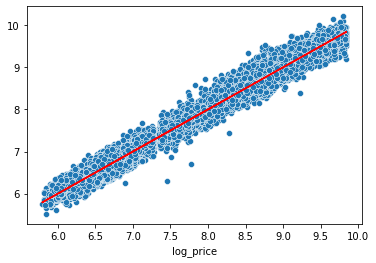

In [45]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

Finally, we can score our model

In [46]:
mse(y_train, y_train_pred)**0.5

0.13896401816064466

> **Note:** We are not using the `score()` method because it doesn't return the RMSE.

### Validating the model

Let's see how does the model work for the test data...

In [47]:
y_test_pred = lin_model_1.predict(X_test)

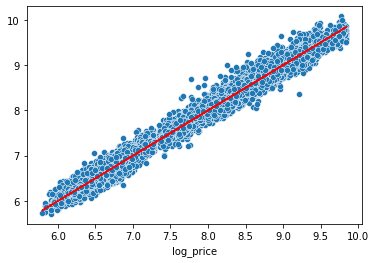

In [48]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [49]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.13956647971047717

The test score is very close to the train score, therefore **the model is valid!** 

> **Discussion:** We will not dive any deeper with this linear model, but there are some issues that should be discussed at this point:
* The linearity assumption
    * The interpretation of the coefficients is very strict. A feature which does not comply with it will harm the model.
    * The linear model is very limited, and is rarely used in practice for complex regressions.
* Interpretation of categorical features
    * The linearity of the model interprets the encoding of the categories as linear, which may be far from reality.
    * The problem can get even worse when the categories are not ordered, then **dummy variables** can be used.
* Error analysis
    * Very often the errors of a model come from a specific "systematic" problem, which can simplify things when discovered.
    * Consider `sns.boxplot(x=X_train.clarity, y=y_train-y_train_pred)`
* Feature engineering
    * `table` and `depth` are already such features...
    * What about interaction features (e.g. the simple [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer)?
* Regularization 
    * There are 3 standard regularization methods for linear regression: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) & [Elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which is a combination of both.
    * They are less intuitive from other regularization methods, so we skip them for now.

> **Your turn:** Try to improve the linear model by adding polynomial features. 

#### Solution

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [ ]:
cols = ['cut', 'color', 'clarity']
pf.fit(diamonds[cols])
# pf.powers_

PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C')

Since the transformer returns a numpy array, we write a simple function to name our columns.

In [ ]:
def name_col(powers):
    return '_'.join([name for power, name in zip(powers, cols) if power])

In [ ]:
poly_features = pd.DataFrame(pf.transform(diamonds[cols]),
                             index=diamonds.index,
                             columns=list(map(name_col, pf.powers_)))
poly_features.head()

,cut,color,clarity,cut_color,cut_clarity,color_clarity
#,,,,,,
1,4.0,5.0,1.0,20.0,4.0,5.0
2,3.0,5.0,2.0,15.0,6.0,10.0
4,3.0,1.0,3.0,3.0,9.0,3.0
5,1.0,0.0,1.0,0.0,1.0,0.0
6,2.0,0.0,5.0,0.0,10.0,0.0


> **Warning:** What will happen if we forget to assign the index in the code above?

In [ ]:
poly_cols = list(set(poly_features.columns) - set(diamonds.columns))
poly_diamonds = diamonds.join(poly_features[poly_cols])
poly_diamonds.head()

,carat,cut,color,clarity,depth,table,log_price,cut_clarity,color_clarity,cut_color
#,,,,,,,,,,
1,0.23,4,5,1,0.615,0.55,5.789960,4.0,5.0,20.0
2,0.21,3,5,2,0.598,0.61,5.789960,6.0,10.0,15.0
4,0.29,3,1,3,0.624,0.58,5.814131,9.0,3.0,3.0
5,0.31,1,0,1,0.633,0.58,5.817111,1.0,0.0,0.0
6,0.24,2,0,5,0.628,0.57,5.820083,10.0,0.0,0.0


In [ ]:
poly_X = poly_diamonds.drop('log_price', axis=1)
y = poly_diamonds.log_price

In [ ]:
poly_X_train, poly_X_test, y_train, y_test = split(poly_X, y, random_state=314159)

In [ ]:
lin_model_2 = LinearRegression().fit(poly_X_train, y_train)

In [ ]:
lin_model_2.coef_


array([ 2.32859269e+00,  2.98817468e-02,  7.28604417e-02,  8.22104299e-02,
        3.34839858e-01,  2.29196048e-01, -3.14422145e-03,  4.98374094e-03,
       -3.28675674e-04])

In [ ]:
y_train_pred = lin_model_2.predict(poly_X_train)

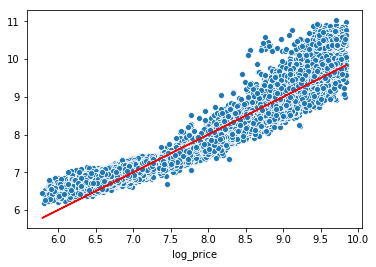

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

Finally, we can score our model

In [ ]:
mse(y_train, y_train_pred)**0.5

0.30660495004848415

# Decision Trees

> **Note:** This is a good point to look at the [chapter about decision trees regression](https://drive.google.com/drive/folders/1RG1nbNEHBxO-z1MUCzMhrKkdC9bc7bjz?usp=sharing)

## First shot

### Fit the model

In [ ]:
X = diamonds.drop('log_price', axis=1)
y = diamonds.log_price

In [ ]:
X_train, X_test, y_train, y_test = split(X, y, random_state=314159)

In [51]:
dt_model_1 = DecisionTreeRegressor().fit(X_train, y_train)

> **Reference:** The [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class.

### Inspect the model

We write a small function to help us visualize the trees ([following this SO answer](https://stackoverflow.com/a/34219424/3121900)).

In [ ]:
def visualize_tree(model, md=5):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

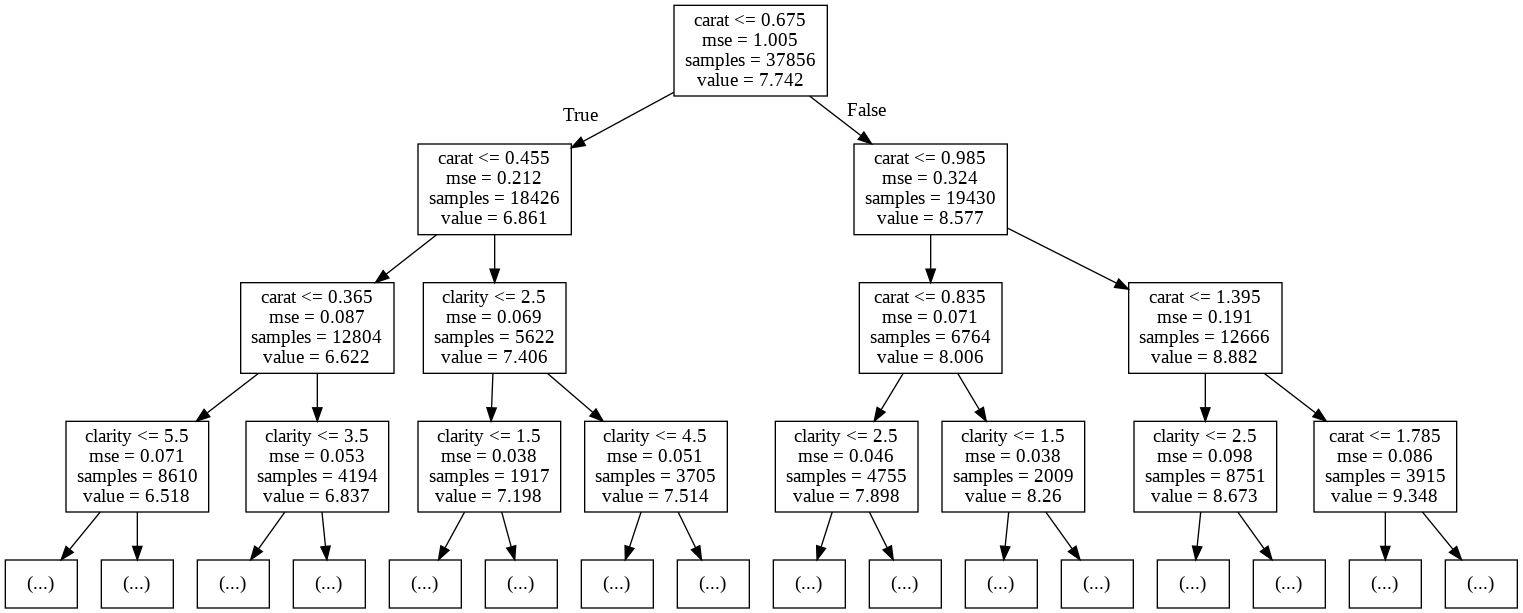

In [ ]:
visualize_tree(dt_model_1, 3)

> **Note:** The default hyper-parameters are set to overfitting, so we cut the tree in the figure. For actual view of the trees in this chapter, it is recommended to use [http://www.webgraphviz.com/](http://www.webgraphviz.com/) with the DOT string resulted by running the function below.

In [ ]:
def print_dot_text(model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns)
    dot_text = dot_data.getvalue()
    print(dot_text)

### Predicting with the model

In [52]:
y_train_pred = dt_model_1.predict(X_train)

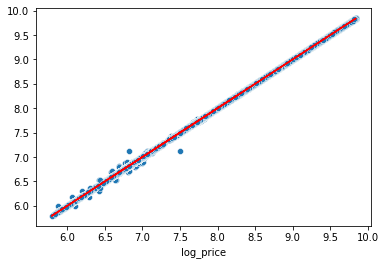

In [53]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [54]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.004016976984388672

**OMG!!!** This is an amazing result! What are we missing?

> **Discussion:** Why $RMSE \neq 0$?

### Validating the model

Let's see how does the model work for the test data...

In [55]:
y_test_pred = dt_model_1.predict(X_test)

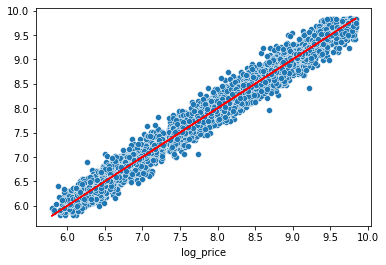

In [56]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [57]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.11894157816807312

## Overfitting

The fact that the **test error** is much worse than the **train error** is called overfitting. It indicates that the model learned the train data too good, and now it cannot generalize good enough for new data.

> **Note:** The illustration is more powerful with small datasets, so we sample the data.

In [ ]:
sub_diamonds = diamonds.sample(1000)
sub_X = sub_diamonds.drop('log_price', axis=1)
sub_y = sub_diamonds.log_price
sub_X_train, sub_X_test, sub_y_train, sub_y_test = split(sub_X, sub_y, random_state=1415)

For this example we will look what happens to the train error and test error when we tune the hyper-parameter called `max_leaf_nodes`.

In [ ]:
complexity = range (2, 201 , 1)
scores = pd.DataFrame(index=complexity, columns=['train', 'test'])

for leafs in complexity:
    model = DecisionTreeRegressor(max_leaf_nodes=leafs).fit(sub_X_train, sub_y_train)
    
    sub_y_train_pred = model.predict(sub_X_train)
    scores.loc[leafs, 'train'] = mse(sub_y_train_pred, sub_y_train) ** 0.5
    
    sub_y_test_pred = model.predict(sub_X_test)
    scores.loc[leafs, 'test'] = mse(sub_y_test_pred, sub_y_test) ** 0.5

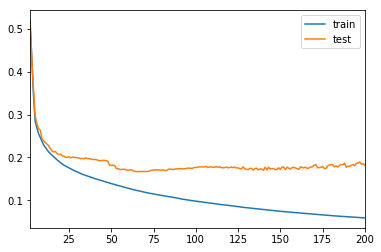

In [ ]:
scores.plot()

> **Discussion:** Discuss the graph.

There are several methods for dealing with overfitting, including dimensionality reduction, regularization and ensemble models. Decision trees are known for having many regularization hyper-parameters, and for our next model we explore them in order to have a more regular model.

> **Discussion:** What is it that we are looking for? How are going to know if the model is overfitted or not?

> **Warning:** Identifying overfitting and dealing with overfitting are two separate tasks. The first is performed with **cross validation** and it will be covered separately.

## Second model

### Fit the model

In [58]:
dt_model_2 = DecisionTreeRegressor(min_samples_split=0.01, min_impurity_split=0.01)

In [59]:
dt_model_2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=0.01,
                      min_samples_leaf=1, min_samples_split=0.01,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

### Inspect the model

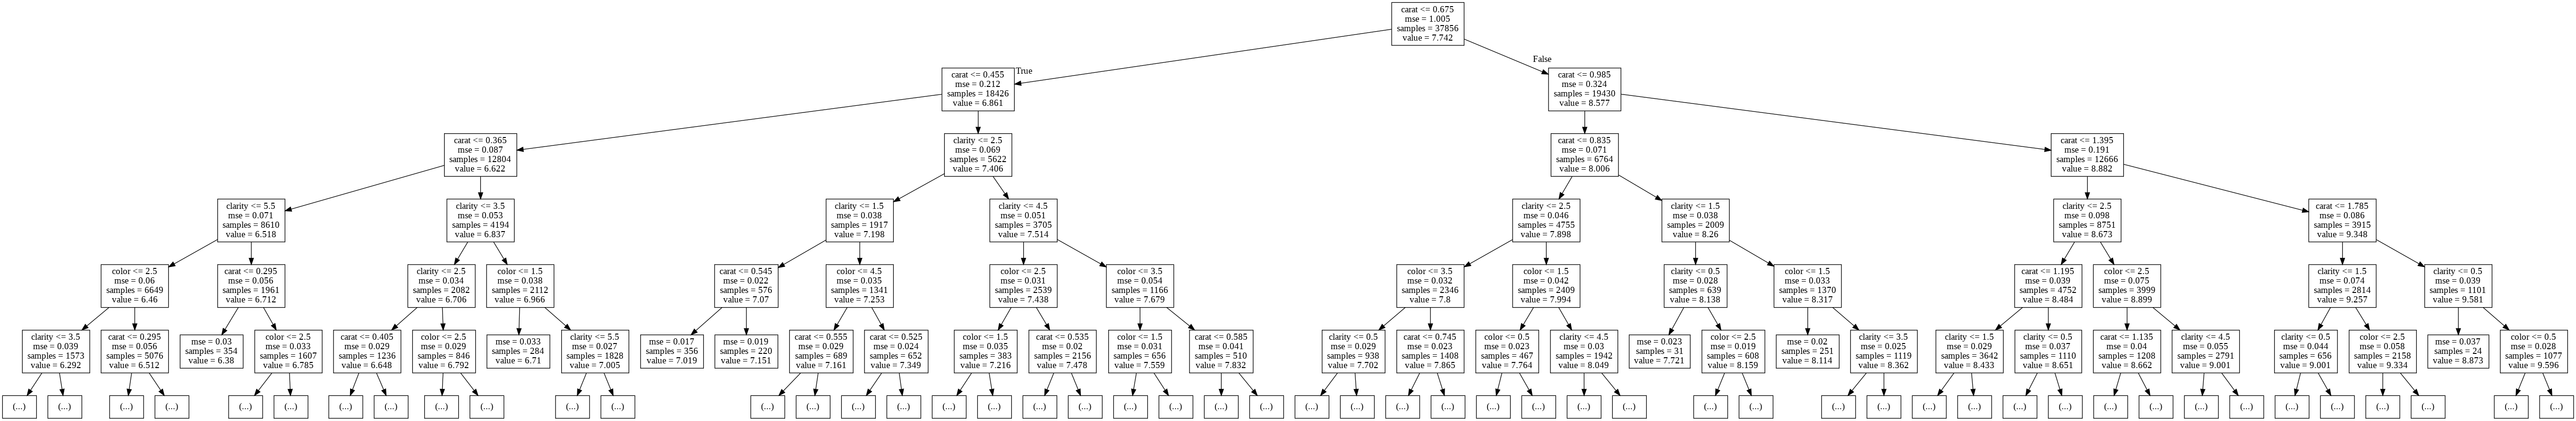

In [ ]:
visualize_tree(dt_model_2)

In [ ]:
# print_dot_text(dt_model_2)

> **Discussion:** Look at the entire tree and discuss whether it is overfitted or not.

### Predicting with the model

In [60]:
y_train_pred = dt_model_2.predict(X_train)

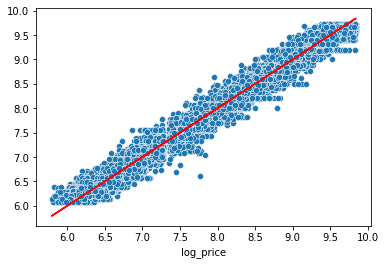

In [61]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [62]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.12873246084557322

### Validating the model

In [63]:
y_test_pred = dt_model_2.predict(X_test)

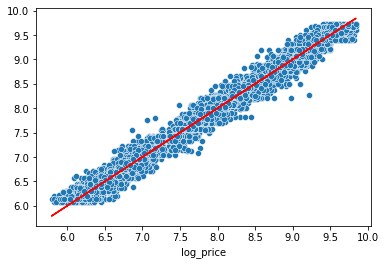

In [64]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [65]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.13060055407996843

Our model is now valid.

> **Your turn:** Try to improve the model while keeping it valid. Don't be afraid to read the documentation and choose your hyper-parameters wisely. (For your convenience - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) class)

> **Discussion:** Consider again the `log1p` scaling of `price` in view of the MSE criterion.

> **Discussion:** Does changing the `random_state` hyper-parameter influence the model? Talk about the relation to cross-validation and random forests.

# K-Nearest Neighbors

> **Note:** This is a good point to look at the [chapter about k-NN regression](https://drive.google.com/drive/folders/1Rse0EPEjrXxCo_VRZTAE94Di0I6nVRI9?usp=sharing)

## First shot

In [ ]:
knn_model_1 = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

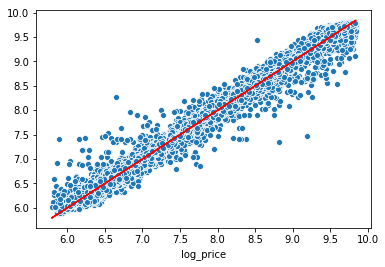

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.10255573249176404

### Validating the model

Let's see how does the model work for the test data...

In [ ]:
y_test_pred = knn_model_1.predict(X_test)

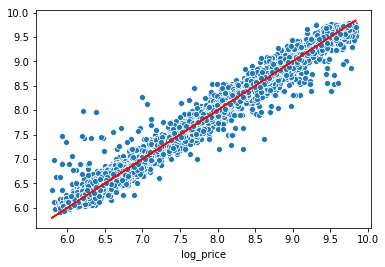

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.1313284522177295

> **Your turn:** Overfit a model with `n_neighbors=1`.

## Scaling the data

It is very useful to have the entire data on the same scale, and this is usually achieved with some scaling. One can scale the bdata in many ways, however Scikit-learn offers 3 simple scalers: [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) & [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Which one of them is the most relevant is a tricky question, and is usually rather intuitive from the nature of the feature.

In [ ]:
X_train.head()

,carat,cut,color,clarity,depth,table
#,,,,,,
28723,0.31,3,5,3,0.627,0.58
9577,1.00,3,6,1,0.595,0.62
23116,1.23,4,4,5,0.618,0.56
34579,0.43,3,4,1,0.618,0.57
4771,0.96,3,2,1,0.594,0.56


The default metric is the Euclidean one. This means that the categorical data has much more influence.
We have two options to deal with this situation - scaling our data or modifying the metric (or both).

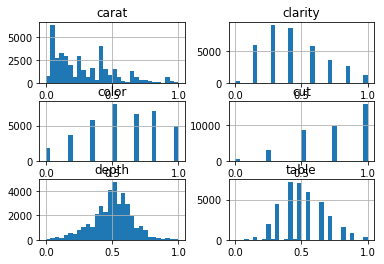

In [ ]:
my_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
ax = X_train_scaled.hist(bins=30)

> **Note:** The scaler is fitted on the train data only.

> **Note:** The result of the scaler is a numpy array.

## Second model

In [ ]:
knn_model_2 = KNeighborsRegressor().fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

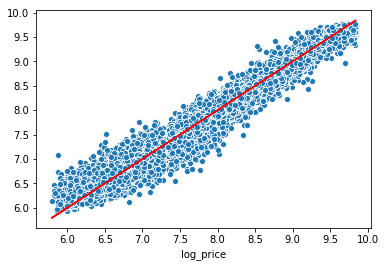

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

0.1412832915474359

### Validating the model

Let's see how does the model work for the test data...

In [ ]:
X_test_scaled = my_scaler.transform(X_test)

In [ ]:
y_test_pred = knn_model_2.predict(X_test_scaled)

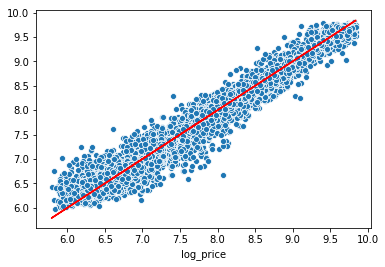

In [ ]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

0.17853642929606464